# <span style="color:yellow">New Classes and Some Functions</span>

In [1]:
from TMclass import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree
from datetime import datetime as DT
from datetime import timedelta as TD

TM3 = {'date':[], 'tm_rate':[], 'duration':[]}

# you have to remove what is inside <eventfile>
with open('../SIFECS_NMP_Segment_2_withLTP10-11FECS.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2023,1,1) and d <= datetime.date(2024,1,1):
        TM3['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TM3['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM3['duration'] += [int(node.attrib.get('duration'))]

TM3['date'] = np.asarray(TM3['date'])
TM3['tm_rate'] = np.asarray(TM3['tm_rate'])
TM3['duration'] = np.asarray(TM3['duration'])

In [53]:
def flush_many(max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    global PHI
    global phi

    def _new_start(start,end):
        start += TD(days=1)
        start = start.replace(hour=22,minute=0,second=0)
        if end > start:
            start = end + TD(hours=1)
        return start
    

    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.level_out(level).n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
    # start += TD(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = min(ndata - n0 - i*n1,n1),level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)
    
def synoptic(mode,t0,t1,cadence,shape,nout,nbits,i,format = False):
    # t0 = DT.fromisoformat('2023-04-15T00:00:00')
    # t1 = DT.fromisoformat('2023-05-01T00:00:00')

    # cad = 6*60
    global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
    deltat = (t1 - t0)/N
    min1 = TD(minutes=1)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min1,cadence=1,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw'); PHI.saving(i,**kw)
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw.crop',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.crop.proc'); PHI.saving(i,**kw)
        else:
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.proc'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

def synoptic_raw(mode,t0,t1,cadence,shape,nbits,i,format = False):
    # t0 = DT.fromisoformat('2023-04-15T00:00:00')
    # t1 = DT.fromisoformat('2023-05-01T00:00:00')

    # cad = 6*60
    global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
    deltat = (t1 - t0)/N
    min1 = TD(minutes=1)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min1,cadence=1,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw'); PHI.saving(i,**kw)
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw.crop'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.crop.pack'); PHI.saving(i,**kw)
        else:
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.pack'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

def FDT_flat(t0,idx,proc='auto',flush='auto',verbose=True):

    global PHI
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    FDTf1 = PHI_MODE('FDT')

    kw = FDTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = FDTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = FDTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = FDTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(FDTf1, label='FDT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return FDTf1

def HRT_flat(t0,idx,proc='auto',flush='auto',verbose=True):
    global PHI
    proc_time = TD(minutes=15)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,10,cadence=40,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(kw['end'],ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

def HRT_kll(t0,idx,proc='auto',flush='auto',verbose=True):
    global PHI
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Kll Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

def plot_flush_per_day(PHI,xlim=None):
    temp = PHI.part1.history    # plt.subplot(121)
    c1 = np.asarray(PHI.part1.history['compr'])
    c2 = np.asarray(PHI.part2.history['compr'])

    d1 = np.asarray(PHI.part1.history['start'])
    d2 = np.asarray(PHI.part2.history['start'])

    starttime = min(d1[0],d2[0])
    endtime = max(max(d1),max(d2))
    t0 = starttime
    times = []
    while starttime.date() <= endtime.date():
        times.append(starttime.date())
        starttime += datetime.timedelta(days=1)
    starttime = t0; del t0
    times_float = [(t - d1[0]).total_seconds() for t in d1]
    times = np.asarray(times)

    newc1 = np.zeros(np.size(times))
    for i,j in zip(d1,c1):
        if j>=0:
            ind = np.where(times == i.date())[0]
            newc1[ind] += j/1e3
    newc1 = np.asarray(newc1)

    newc2 = np.zeros(np.size(times))
    for i,j in zip(d2,c2):
        if j>=0:
            ind = np.where(times == i.date())[0]
            newc2[ind] += j/1e3
    newc2 = np.asarray(newc2)


    plt.figure(figsize=(15,12))
    # plt.plot_date(times,newc1,color='blue',linestyle='-',marker='.',label='partition 1')
    # plt.plot_date(times,newc2,color='red',linestyle='-',marker='.',label='partition 2')
    plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total: '+str(round(np.sum(newc1+newc2),1))+' GB')
    plt.gcf().autofmt_xdate()
    plt.grid()
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)


(-164.48114590424996, 5695.06179926925)

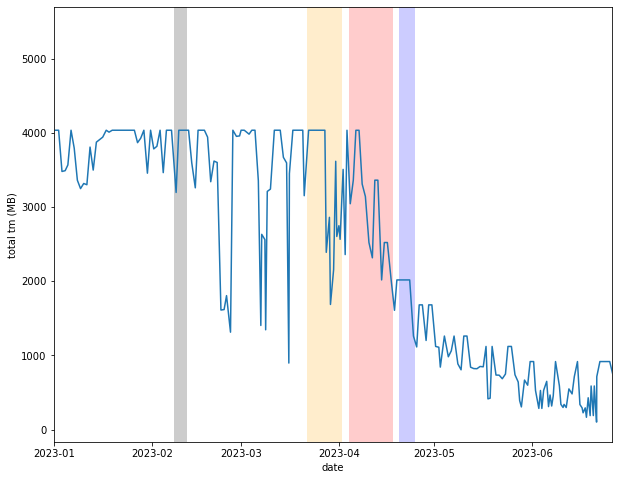

In [3]:
plt.figure(figsize=(10,8))
plt.plot(TM3['date'], (TM3['tm_rate']*TM3['duration'])/8/1e6)#; plt.ylim(0,5000)
ylim = plt.gca().get_ylim()
plt.fill_betweenx(ylim,DT(2023,2,8),DT(2023,2,12),facecolor='black',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,3,22),DT(2023,4,2),facecolor='orange',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,4,4),DT(2023,4,18),facecolor='red',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,4,20),DT(2023,4,25),facecolor='blue',alpha=.2)
plt.xlim(datetime.date(2023,1,1),datetime.date(2023,6,26))
plt.ylabel('total tm (MB)')
plt.xlabel('date')
plt.ylim(ylim)

# <span style="color:white">*out of RSWs*</span>

## <span style="color:blue">R_FULL_LRES_HCAD_Full-Disk-Helioseismology</span>


In [4]:
t0 = DT.fromisoformat('2023-02-08T00:00:00')
t1 = DT.fromisoformat('2023-02-10T00:00:00')
PHI = PHI_MEMORY(t0)
phi = PHI_MEMORY(t0)

hcrop = 768
hsm_1 = PHI_MODE('FDT')
kw = hsm_1.observation(t0,t1,cadence=1,shape=(2048,hcrop,1,6)); PHI.saving(1,**kw)

# t0 = hsm_1.raw.end

# PHI.copy_partition(1,t0)
# PHI.format_partition(1,PHI.part1.history['end'][-1])


t0 = DT.fromisoformat('2023-02-10T00:00:00')
t1 = DT.fromisoformat('2023-02-12T00:00:00')
hsm_2 = PHI_MODE('FDT')
kw = hsm_2.observation(t0,t1,cadence=1,shape=(2048,hcrop,1,6)); PHI.saving(2,**kw)

t0 = hsm_2.raw.end

kw = hsm_1.cropping(t0,ndata=-1,crop=[hcrop,hcrop],level='raw'); PHI.saving(1,**kw)
kw = hsm_1.packing(hsm_1.raw.crop.end,ndata=-1,level='raw.crop'); PHI.saving(1,**kw)

# kw = hsm_1.compressing(hsm_1.raw.pack.end, nbits = 6, ndata = -1,level='raw.pack'); PHI.saving(1,**kw)
hsm_1, kw = flush_many([1350,1350], 2.4, hsm_1, kw['end'], 6, -1, 'raw.crop.pack',1)

t0 = hsm_1.raw.crop.pack.compr.end
kw = hsm_2.cropping(t0,ndata=-1,crop=[hcrop,hcrop],level='raw'); PHI.saving(2,**kw)
kw = hsm_2.packing(hsm_2.raw.crop.end,ndata=-1,level='raw.crop'); PHI.saving(2,**kw)

# kw = hsm_2.compressing(a1_2.raw.pack.end, nbits = 6, ndata = -1,level='raw.pack'); PHI.saving(2,**kw)
hsm_2, kw = flush_many([1350,1350], 2.4, hsm_2, kw['end'], 6, -1, 'raw.crop.pack',2)

end = kw['end']
########################################################
printp(hsm_1, label='R_FULL_LRES_HCAD_Full-Disk-Helioseismology - Partition 1')
print('==========================\n')
printp(hsm_2, label='R_FULL_LRES_HCAD_Full-Disk-Helioseismology - Partition 2')
# plot_tot(PHI)

Days needed: 6
Days needed: 6
R_FULL_LRES_HCAD_Full-Disk-Helioseismology - Partition 1
number of datasets: 2880
cadence: 1 mins
duration: 2 days, 0:00:00
amount of raw-data at 32 bits: 131835.9 MiB, 45.8 MiB per dataset
crop size: 768
amount of crop-data at 32 bits: 65918.0 MiB, 22.9 MiB per dataset
cropping time: 1 day, 4:00:00
amount of pack-data at 16 bits: 43945.3 MiB, 15.3 MiB per dataset
packing time: 1 day, 12:00:00
amount of compressed data + metadata at 6 bits: 7314.7 MiB, 2.5 MiB per dataset
compressing (+ flushing) time: 17:02:40.312320
amount of metadata:  69120.9 MiB
amount of memory usage: 241699.2 MiB


R_FULL_LRES_HCAD_Full-Disk-Helioseismology - Partition 2
number of datasets: 2880
cadence: 1 mins
duration: 2 days, 0:00:00
amount of raw-data at 32 bits: 131835.9 MiB, 45.8 MiB per dataset
crop size: 768
amount of crop-data at 32 bits: 65918.0 MiB, 22.9 MiB per dataset
cropping time: 1 day, 4:00:00
amount of pack-data at 16 bits: 43945.3 MiB, 15.3 MiB per dataset
packing

In [5]:
print('cropping and packing duration:',(hsm_1.raw.crop.pack.time + hsm_1.raw.crop.time)*2)
print('compression duration:',(hsm_1.raw.crop.pack.compr.time)*2)

cropping and packing duration: 5 days, 8:00:00
compression duration: 1 day, 10:05:20.624640


## <span style="color:magenta">***RESET NANDs***</span>

In [6]:
print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# print('TM time:',round((PHI.part1.compr + PHI.part2.compr)/2151.3,2), 'days')
# PHI.format_partition(1,DT(2023,1,29,16,0,0))
# PHI.format_partition(2,end + TD(hours=1))
# PHI.format_partition(1,end + TD(hours=1))
# PHI.format_partition(2,PHI.part1.history['end'][-1] + TD(hours=.5))
PHI.format_partition(1,DT(2023,2,28,1,0,0))
PHI.format_partition(2,DT(2023,2,28,6,0,0))

amount of compressed data + metadata in partition 1: 7.67 GB
amount of compressed data + metadata in partition 2: 7.67 GB


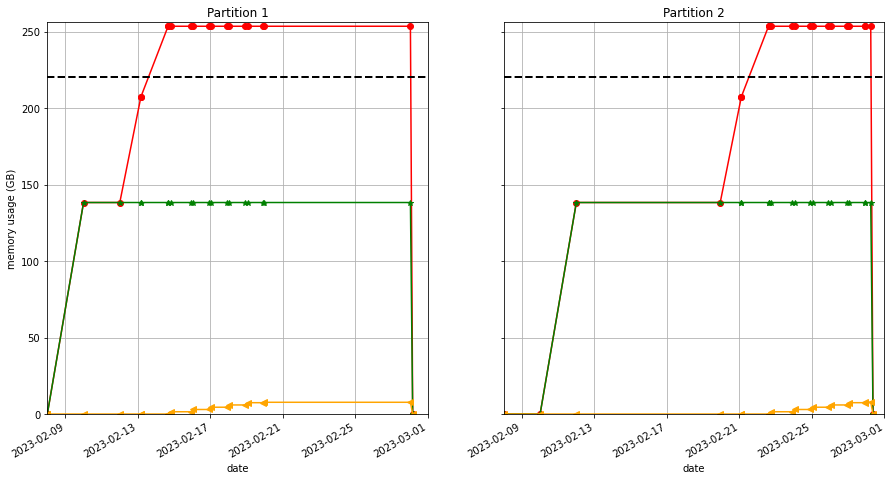

In [7]:
plot_tot(PHI,ylim=(0,256),xlim=(DT(2023,2,8),DT(2023,3,1)))

In [8]:
phi = PHI_MEMORY(DT.fromisoformat('2023-03-15T00:00:00'))

## <span style="color:blue">CC_OFFPOI_OOF </span>

PSP context

In [9]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-03-15T11:45:00')
t1 = DT.fromisoformat('2023-03-15T14:45:00')
psp = PHI_MODE('HRT')
kw = psp.observation(t0,t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)

t0 = psp.raw.end+TD(minutes=20)
kw = psp.packing(t0,ndata=-1,level='raw'); phi.saving(id,**kw); PHI.saving(id,**kw); 
kw = psp.compressing(psp.raw.pack.end+TD(minutes=10), nbits = 6, ndata = -1,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw);

########################################################
printp(psp, label='CC_OFFPOI_OOF - PSP context')


CC_OFFPOI_OOF - PSP context
number of datasets: 3
cadence: 60 mins
duration: 3:00:00
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 618.0 MiB, 206.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 216.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:30:12.155328
amount of metadata:  48.027 MiB
amount of memory usage: 1808.2 MiB



## <span style="color:blue">CC_OFFPOI_STRAYLIGHT </span>

In [10]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-03-20T00:00:00')
t1 = DT.fromisoformat('2023-03-20T05:36:00')
stray = PHI_MODE('HRT')
kw = stray.observation(t0,3,cadence=90,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)

t0 = stray.raw.end+TD(minutes=20)
kw = stray.packing(t0,ndata=-1,level='raw'); phi.saving(id,**kw); PHI.saving(id,**kw); 
kw = stray.compressing(stray.raw.pack.end+TD(minutes=10), nbits = 6, ndata = -1,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw);

########################################################
printp(stray, label='CC_OFFPOI_STRAYLIGHT')


CC_OFFPOI_STRAYLIGHT
number of datasets: 3
cadence: 90 mins
duration: 4:30:00
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 618.0 MiB, 206.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 216.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:30:12.155328
amount of metadata:  48.027 MiB
amount of memory usage: 1808.2 MiB



## <span style="color:blue">CC_ROLLS_RS </span>

8 roll positions

In [11]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-03-20T06:00:00')
t1 = DT.fromisoformat('2023-03-20T13:30:00')
roll = PHI_MODE('FDT')
kw = roll.observation(t0,8,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)

t0 = roll.raw.end+TD(minutes=20)
kw = roll.packing(t0,ndata=-1,level='raw'); phi.saving(id,**kw); PHI.saving(id,**kw); 
kw = roll.compressing(roll.raw.pack.end+TD(minutes=10), nbits = 6, ndata = -1,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw);

########################################################
printp(roll, label='CC_ROLLS_RS')


CC_ROLLS_RS
number of datasets: 8
cadence: 60 mins
duration: 8:00:00
amount of raw-data at 32 bits: 3173.8 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1647.9 MiB, 206.0 MiB per dataset
packing time: 0:12:00
amount of compressed data + metadata at 6 bits: 576.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:20:32.414208
amount of metadata:  128.072 MiB
amount of memory usage: 4821.8 MiB



## <span style="color:green">HRT Flat 1</span>

In [12]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-03-21T00:00:00')
t1 = DT.fromisoformat('2023-03-21T10:00:00')
HRTflat1 = HRT_flat(t0,id,verbose=False)
########################################################
printp(HRTflat1, label="HRT FLAT 1 (21/03/2023)")

HRT FLAT 1 (21/03/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:green">FDT Flat 1 </span>

In [13]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-03-21T20:00:00')
t1 = DT.fromisoformat('2023-03-21T21:00:00')
FDTflat1 = FDT_flat(t0,id,DT(2023,3,22,12,30),verbose=False)
########################################################
printp(FDTflat1, label="FDT FLAT 1 (21/03/2023)")

FDT FLAT 1 (21/03/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4173.3 MiB



# <span style="color:orange">*RSW 7*</span>

## <span style="color:blue">Crazy Mosaic</span>

In [14]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-03-22T00:00:00')
t1 = t0 + TD(minutes=175) #25 datasets
crazy = PHI_MODE('HRT')

kw = crazy.observation(t0,25,cadence=7,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = crazy.packing(DT(2023,3,22,5,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = crazy.compressing(DT(2023,3,22,22,0,0),ndata=-1,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(crazy, label='Crazy Mosaic')


Crazy Mosaic
number of datasets: 25
cadence: 7 mins
duration: 2:55:00
amount of raw-data at 32 bits: 9918.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 5149.8 MiB, 206.0 MiB per dataset
packing time: 0:37:30
amount of compressed data + metadata at 6 bits: 1800.2 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 4:11:41.294400
amount of metadata:  400.225 MiB
amount of memory usage: 15068.1 MiB



## <span style="color:blue">Eruption Watch</span>

In [15]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-03-22T06:00:00')
t1 = DT.fromisoformat('2023-03-27T06:10:00')
ew1 = PHI_MODE('FDT')
crop = 1536

kw = ew1.observation(t0,t1,cadence=360,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = ew1.cropping(DT(2023,3,27,1,0,0),crop=crop,ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = ew1.packing(kw['end']+TD(minutes=5),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = ew1.compressing(DT(2023,3,27,22,0,0),ndata=-1,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
t0 = DT.fromisoformat('2023-03-27T02:00:00')
# t1 = DT.fromisoformat('2023-03-27T05:10:00')
FDTcc = PHI_MODE('FDT')
crop = 1536

kw = FDTcc.observation(t0,30,cadence=100/6,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTcc.cropping(kw['end']+TD(minutes=5),crop=crop,ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTcc.packing(kw['end']+TD(minutes=5),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTcc.compressing(DT(2023,3,27,22,30,0),ndata=-1,nbits=6,level='raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)


########################################################
printp(ew1, label='Eruption Watch 1')
printp(FDTcc, label='FDT cross calibration')


Eruption Watch 1
number of datasets: 20
cadence: 360 mins
duration: 5 days, 0:10:00
amount of raw-data at 32 bits: 5950.9 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 4577.6 MiB, 228.9 MiB per dataset
cropping time: 0:23:20
amount of pack-data at 16 bits: 2441.4 MiB, 122.1 MiB per dataset
packing time: 0:30:00
amount of compressed data + metadata at 6 bits: 810.2 MiB, 40.5 MiB per dataset
compressing (+ flushing) time: 1:53:16.212480
amount of metadata:  480.18 MiB
amount of memory usage: 12970.0 MiB

FDT cross calibration
number of datasets: 30
cadence: 16.666666666666668 mins
duration: 8:20:00
amount of raw-data at 32 bits: 8926.4 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 6866.5 MiB, 228.9 MiB per dataset
cropping time: 0:35:00
amount of pack-data at 16 bits: 3662.1 MiB, 122.1 MiB per dataset
packing time: 0:45:00
amount of compressed data + metadata at 6 bits: 1215.3 MiB, 40.5 MiB per dataset
compressing (+ flushing) tim

## <span style="color:blue">Connection Mosaic</span>

12 pointings, 4h each, used for HRTcc

In [16]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-03-27T06:00:00')
t1 = DT.fromisoformat('2023-03-29T06:18:51')
CM1 = PHI_MODE('HRT')

kw = CM1.observation(t0,t1,cadence=30,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = CM1.packing(DT(2023,4,2,10,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
CM1, kw = flush_many([1200,1200],72,CM1,DT(2023,4,2,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(CM1, label='Connection Mosaic')


Days needed: 7
Connection Mosaic
number of datasets: 96
cadence: 30 mins
duration: 2 days, 0:18:51
amount of raw-data at 32 bits: 38085.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 19775.4 MiB, 206.0 MiB per dataset
packing time: 2:24:00
amount of compressed data + metadata at 6 bits: 6912.8 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 16:06:28.970496
amount of metadata:  1536.054 MiB
amount of memory usage: 57861.3 MiB



## <span style="color:blue">RS-burst 1</span>
30m high cadence, FDT otherwise 1h cadence

In [17]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-03-29T08:00:00')
t1 = DT.fromisoformat('2023-03-29T12:00:51')
RShrt1 = PHI_MODE('HRT')
RSfdt1 = PHI_MODE('FDT')

kw = RShrt1.observation(t0,30,cadence=1,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RSfdt1.observation(t0+TD(minutes=60),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt1.packing(DT(2023,4,2,13,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RSfdt1.packing(DT(2023,4,2,14,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RSfdt1.compressing(DT(2023,4,2,22,0,0),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
RShrt1, kw = flush_many([1200,1200],72,RShrt1,DT(2023,4,9,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(RShrt1, label='RS-burst HRT 1')
printp(RSfdt1, label='RS-burst FDT 1')


Days needed: 3
RS-burst HRT 1
number of datasets: 30
cadence: 1 mins
duration: 0:30:00
amount of raw-data at 32 bits: 11901.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 6179.8 MiB, 206.0 MiB per dataset
packing time: 0:45:00
amount of compressed data + metadata at 6 bits: 2160.3 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 5:02:01.553280
amount of metadata:  480.0 MiB
amount of memory usage: 18081.7 MiB

RS-burst FDT 1
number of datasets: 3
cadence: 60 mins
duration: 3:00:51
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 618.0 MiB, 206.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 216.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:30:12.155328
amount of metadata:  48.027 MiB
amount of memory usage: 1808.2 MiB



## <span style="color:blue">Nanoflares 1</span>


In [18]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-03-29T13:00:00')
t1 = DT.fromisoformat('2023-03-29T16:00:00')
nanohrt1 = PHI_MODE('HRT')
nanofdt1 = PHI_MODE('FDT')

kw = nanohrt1.observation(t0,30,cadence=1,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt1.observation(t0+TD(minutes=60),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt1.packing(DT(2023,4,2,16,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt1.packing(DT(2023,4,2,17,00,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt1.compressing(DT(2023,4,2,22,30,0),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
nanohrt1, kw = flush_many([1200,1200],72,nanohrt1,DT(2023,4,11,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(nanohrt1, label='Nanoflares HRT 1')
printp(nanofdt1, label='Nanoflares FDT 1')


Days needed: 3
Nanoflares HRT 1
number of datasets: 30
cadence: 1 mins
duration: 0:30:00
amount of raw-data at 32 bits: 11901.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 6179.8 MiB, 206.0 MiB per dataset
packing time: 0:45:00
amount of compressed data + metadata at 6 bits: 2160.3 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 5:02:01.553280
amount of metadata:  480.0 MiB
amount of memory usage: 18081.7 MiB

Nanoflares FDT 1
number of datasets: 2
cadence: 60 mins
duration: 2:00:00
amount of raw-data at 32 bits: 793.5 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 412.0 MiB, 206.0 MiB per dataset
packing time: 0:03:00
amount of compressed data + metadata at 6 bits: 144.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:20:08.103552
amount of metadata:  32.018 MiB
amount of memory usage: 1205.4 MiB



## <span style="color:blue">Polar Observations 1</span>

In [19]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-03-29T20:00:00')
t1 = DT.fromisoformat('2023-03-29T23:00:00')
polar1 = PHI_MODE('HRT')
crop = 1024

kw = polar1.observation(t0,t1,cadence=20,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar1.cropping(kw['end']+TD(minutes=10),crop=crop,ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar1.packing(kw['end']+TD(minutes=5),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar1.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(polar1, label='Polar Observations 1')


Polar Observations 1
number of datasets: 9
cadence: 20 mins
duration: 3:00:00
amount of raw-data at 32 bits: 1853.9 MiB, 206.0 MiB per dataset
crop size: 1024
amount of crop-data at 32 bits: 961.3 MiB, 106.8 MiB per dataset
cropping time: 0:05:15
amount of pack-data at 16 bits: 549.3 MiB, 61.0 MiB per dataset
packing time: 0:06:45
amount of compressed data + metadata at 6 bits: 162.1 MiB, 18.0 MiB per dataset
compressing (+ flushing) time: 0:22:39.602496
amount of metadata:  216.081 MiB
amount of memory usage: 3364.6 MiB



## <span style="color:blue">Slow Wind Connection 1</span>
3 HRT burst (1h@5m)


In [20]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-03-30T08:00:00')
t1 = DT.fromisoformat('2023-04-02T00:00:00')
SW1 = PHI_MODE('HRT')

kw = SW1.observation(t0,12,cadence=5,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW1.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW1.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW1.observation(t0+TD(days=1),12,cadence=5,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW1.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW1.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW1.observation(t0+TD(days=2),12,cadence=5,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW1.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW1.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(SW1, label='Slow Wind Connection 1')


Slow Wind Connection 1
number of datasets: 36
cadence: 5 mins
duration: 1:00:00
amount of raw-data at 32 bits: 14282.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 7415.8 MiB, 206.0 MiB per dataset
packing time: 0:54:00
amount of compressed data + metadata at 6 bits: 2592.3 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 6:02:25.863936
amount of metadata:  192.108 MiB
amount of memory usage: 21698.0 MiB



## <span style="color:green">HRT Flat 2</span>

In [21]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-04-02T00:00:00')
t1 = DT.fromisoformat('2023-04-02T10:00:00')
HRTflat2 = HRT_flat(t0,id,verbose=False)
########################################################
printp(HRTflat1, label="HRT FLAT 2 (02/04/2023)")

HRT FLAT 2 (02/04/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:green">FDT Flat 2</span>

Download raw flats

In [22]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-03T10:29:06')
t1 = DT.fromisoformat('2023-04-03T11:24:06')
FDTflat2 = FDT_flat(t0,id,verbose=False)
kw = FDTflat2.packing(DT(2023,4,3,17,0,0),ndata=9,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTflat2.compressing(kw['end']+TD(minutes=10),ndata=9,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(FDTflat2, label="FDT FLAT 2 (03/04/2023)")

FDT FLAT 2 (03/04/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2059.9 MiB, 206.0 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 720.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:40:40.517760
amount of metadata:  80.081 MiB
amount of memory usage: 6027.2 MiB



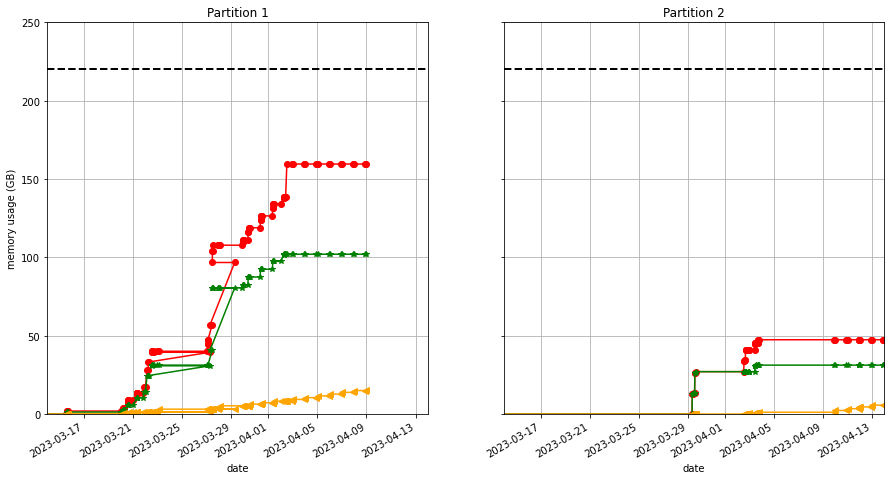

In [23]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,4,14,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)


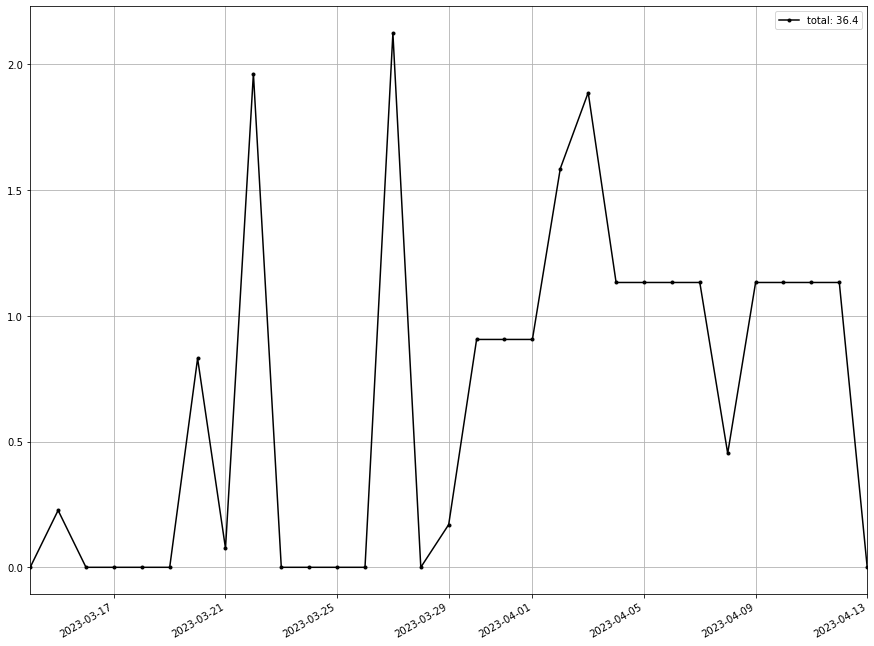

In [24]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,4,13,0,0,0))
plot_flush_per_day(PHI,xlim)

We must empty partition 1 by April 10 to acquire the 6h QS SOOP

We can put almost everything in partition one from RSW 7 (so far RS-burst and Nanoflares1 in NAND 2)

# <span style="color:red">*RSW 8*</span>

## <span style="color:blue">Nanoflares 2</span>

In [25]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-04T04:08:08')
t1 = DT.fromisoformat('2023-04-04T07:08:08')
nanohrt2 = PHI_MODE('HRT')
nanofdt2 = PHI_MODE('FDT')

kw = nanohrt2.observation(t0,30,cadence=1,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt2.observation(t0+TD(minutes=30),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt2.packing(DT(2023,4,4,7,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt2.packing(DT(2023,4,4,8,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt2.compressing(DT(2023,4,4,22,30,0),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
nanohrt2, kw = flush_many([1200,1200],72,nanohrt2,DT(2023,4,12,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(nanohrt2, label='Nanoflares HRT 2')
printp(nanofdt2, label='Nanoflares FDT 2')


Days needed: 3
Nanoflares HRT 2
number of datasets: 30
cadence: 1 mins
duration: 0:30:00
amount of raw-data at 32 bits: 11901.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 6179.8 MiB, 206.0 MiB per dataset
packing time: 0:45:00
amount of compressed data + metadata at 6 bits: 2160.3 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 5:02:01.553280
amount of metadata:  480.0 MiB
amount of memory usage: 18081.7 MiB

Nanoflares FDT 2
number of datasets: 2
cadence: 60 mins
duration: 2:30:00
amount of raw-data at 32 bits: 793.5 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 412.0 MiB, 206.0 MiB per dataset
packing time: 0:03:00
amount of compressed data + metadata at 6 bits: 144.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:20:08.103552
amount of metadata:  32.018 MiB
amount of memory usage: 1205.4 MiB



## <span style="color:blue">Bright Points</span>

In [26]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-04-04T12:00:00')
t1 = DT.fromisoformat('2023-04-04T20:00:00')
BP = PHI_MODE('HRT')
crop = 1280

kw = BP.observation(t0,t1,cadence=30,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = BP.cropping(kw['end']+TD(minutes=10),crop=crop,ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = BP.packing(kw['end']+TD(minutes=5),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = BP.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(BP, label='Bright Points')


Bright Points
number of datasets: 16
cadence: 30 mins
duration: 8:00:00
amount of raw-data at 32 bits: 4028.3 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 2563.5 MiB, 160.2 MiB per dataset
cropping time: 0:18:40
amount of pack-data at 16 bits: 1342.8 MiB, 83.9 MiB per dataset
packing time: 0:24:00
amount of compressed data + metadata at 6 bits: 450.1 MiB, 28.1 MiB per dataset
compressing (+ flushing) time: 1:02:56.025600
amount of metadata:  384.144 MiB
amount of memory usage: 7934.6 MiB



## <span style="color:blue">Sunspot Oscillation</span>

In [27]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-05T00:00:00')
t1 = DT.fromisoformat('2023-04-05T08:00:00')
SO = PHI_MODE('HRT')
crop = 1280

kw = SO.observation(t0,t1,cadence=30,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SO.cropping(kw['end']+TD(minutes=10),crop=crop,ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SO.packing(kw['end']+TD(minutes=5),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SO.compressing(DT(2023,4,5,23,0,0),ndata=-1,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(SO, label='Sunspot Oscillation')


Sunspot Oscillation
number of datasets: 16
cadence: 30 mins
duration: 8:00:00
amount of raw-data at 32 bits: 4028.3 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 2563.5 MiB, 160.2 MiB per dataset
cropping time: 0:18:40
amount of pack-data at 16 bits: 1342.8 MiB, 83.9 MiB per dataset
packing time: 0:24:00
amount of compressed data + metadata at 6 bits: 450.1 MiB, 28.1 MiB per dataset
compressing (+ flushing) time: 1:02:56.025600
amount of metadata:  384.144 MiB
amount of memory usage: 7934.6 MiB



## <span style="color:blue">Major Flare Watch</span>

In [28]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-05T09:00:00')
t1 = DT.fromisoformat('2023-04-05T17:00:00')
MFW = PHI_MODE('HRT')
crop = 1280

kw = MFW.observation(t0,t1,cadence=30,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = MFW.cropping(kw['end']+TD(minutes=10),crop=crop,ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = MFW.packing(kw['end']+TD(minutes=5),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = MFW.compressing(DT(2023,4,6,23,0,0),ndata=-1,nbits=6,level = 'raw.crop.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(MFW, label='Sunspot Oscillation')


Sunspot Oscillation
number of datasets: 16
cadence: 30 mins
duration: 8:00:00
amount of raw-data at 32 bits: 4028.3 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 2563.5 MiB, 160.2 MiB per dataset
cropping time: 0:18:40
amount of pack-data at 16 bits: 1342.8 MiB, 83.9 MiB per dataset
packing time: 0:24:00
amount of compressed data + metadata at 6 bits: 450.1 MiB, 28.1 MiB per dataset
compressing (+ flushing) time: 1:02:56.025600
amount of metadata:  384.144 MiB
amount of memory usage: 7934.6 MiB



## <span style="color:blue">Nanoflares 3</span>

In [29]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-06T02:00:00')
t1 = DT.fromisoformat('2023-04-06T05:00:00')
nanohrt3 = PHI_MODE('HRT')
nanofdt3 = PHI_MODE('FDT')

kw = nanohrt3.observation(t0,30,cadence=1,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt3.observation(t0+TD(minutes=30),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt3.packing(DT(2023,4,6,5,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt3.packing(DT(2023,4,6,6,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt3.compressing(DT(2023,4,6,22,30,0),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
nanohrt3, kw = flush_many([1200,1200],72,nanohrt3,DT(2023,4,15,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(nanohrt3, label='Nanoflares HRT 3')
printp(nanofdt3, label='Nanoflares FDT 3')


Days needed: 3
Nanoflares HRT 3
number of datasets: 30
cadence: 1 mins
duration: 0:30:00
amount of raw-data at 32 bits: 11901.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 6179.8 MiB, 206.0 MiB per dataset
packing time: 0:45:00
amount of compressed data + metadata at 6 bits: 2160.3 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 5:02:01.553280
amount of metadata:  480.0 MiB
amount of memory usage: 18081.7 MiB

Nanoflares FDT 3
number of datasets: 2
cadence: 60 mins
duration: 2:30:00
amount of raw-data at 32 bits: 793.5 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 412.0 MiB, 206.0 MiB per dataset
packing time: 0:03:00
amount of compressed data + metadata at 6 bits: 144.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:20:08.103552
amount of metadata:  32.018 MiB
amount of memory usage: 1205.4 MiB



## <span style="color:blue">RS-burst 2</span>

In [30]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-06T08:00:00')
t1 = DT.fromisoformat('2023-04-06T11:30:00')
RShrt2 = PHI_MODE('HRT')
RSfdt2 = PHI_MODE('FDT')

kw = RShrt2.observation(t0,30,cadence=1,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RSfdt2.observation(t0+TD(minutes=30),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt2.packing(DT(2023,4,6,12,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RSfdt2.packing(DT(2023,4,6,13,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RSfdt2.compressing(DT(2023,4,7,22,30,0),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
RShrt2, kw = flush_many([1200,1200],72,RShrt2,DT(2023,4,18,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(RShrt2, label='RS-burst HRT 2')
printp(RSfdt2, label='RS-burst FDT 2')

Days needed: 3
RS-burst HRT 2
number of datasets: 30
cadence: 1 mins
duration: 0:30:00
amount of raw-data at 32 bits: 11901.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 6179.8 MiB, 206.0 MiB per dataset
packing time: 0:45:00
amount of compressed data + metadata at 6 bits: 2160.3 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 5:02:01.553280
amount of metadata:  480.0 MiB
amount of memory usage: 18081.7 MiB

RS-burst FDT 2
number of datasets: 3
cadence: 60 mins
duration: 3:00:00
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 618.0 MiB, 206.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 216.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:30:12.155328
amount of metadata:  48.027 MiB
amount of memory usage: 1808.2 MiB



## <span style="color:green">FDT Flat 3</span>

In [31]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-04-06T18:00:00')
t1 = DT.fromisoformat('2023-04-06T19:00:00')
FDTflat3 = FDT_flat(t0,id,DT(2023,4,7,1,0,0),verbose=False)
########################################################
printp(FDTflat3, label="FDT FLAT 3 (06/04/2023)")

FDT FLAT 3 (06/04/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4173.3 MiB



## <span style="color:blue">Coronal Dynamics 1</span>

In [32]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-04-06T20:00:00')
t1 = DT.fromisoformat('2023-04-08T21:00:00')
CD1 = PHI_MODE('FDT')

synoptic_raw(CD1,t0,t1,360,(2048,2048,4,6),6,id)

########################################################
printp(CD1, label='Coronal Dynamics 1')


Coronal Dynamics 1
number of datasets: 8
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 3173.8 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1647.9 MiB, 206.0 MiB per dataset
packing time: 0:12:00
amount of compressed data + metadata at 6 bits: 576.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:20:32.414208
amount of metadata:  16.009 MiB
amount of memory usage: 4821.8 MiB



## <span style="color:blue">RS-burst 3</span>
Sebas SOOP

In [33]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-07T17:30:00')
t1 = DT.fromisoformat('2023-04-07T18:30:00')
RS3 = PHI_MODE('HRT')

kw = RS3.observation(t0,t1,cadence=5,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RS3.packing(DT(2023,4,2,10,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
RS3, kw = flush_many([800,800],72,RS3,DT(2023,4,21,22,0,0),6,-1,'raw.pack',id); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(RS3, label='Connection Mosaic')


Days needed: 2
Connection Mosaic
number of datasets: 12
cadence: 5 mins
duration: 1:00:00
amount of raw-data at 32 bits: 4760.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2471.9 MiB, 206.0 MiB per dataset
packing time: 0:18:00
amount of compressed data + metadata at 6 bits: 864.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 2:00:48.621312
amount of metadata:  192.018 MiB
amount of memory usage: 7232.7 MiB



## <span style="color:blue">CH Bounday Expansion</span>

In [34]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-09T00:00:00')
t1 = DT.fromisoformat('2023-04-10T00:00:00')
CH1 = PHI_MODE('FDT')

synoptic_raw(CH1,t0,t1,360,(2048,2048,4,6),6,id)

########################################################
printp(CH1, label='CH boundary expansion')


CH boundary expansion
number of datasets: 4
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 824.0 MiB, 206.0 MiB per dataset
packing time: 0:06:00
amount of compressed data + metadata at 6 bits: 288.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:40:16.207104
amount of metadata:  16.009 MiB
amount of memory usage: 2410.9 MiB



## <span style="color:magenta">***RESET NAND 1***</span>

amount of compressed data + metadata in partition 1: 16.58 GB


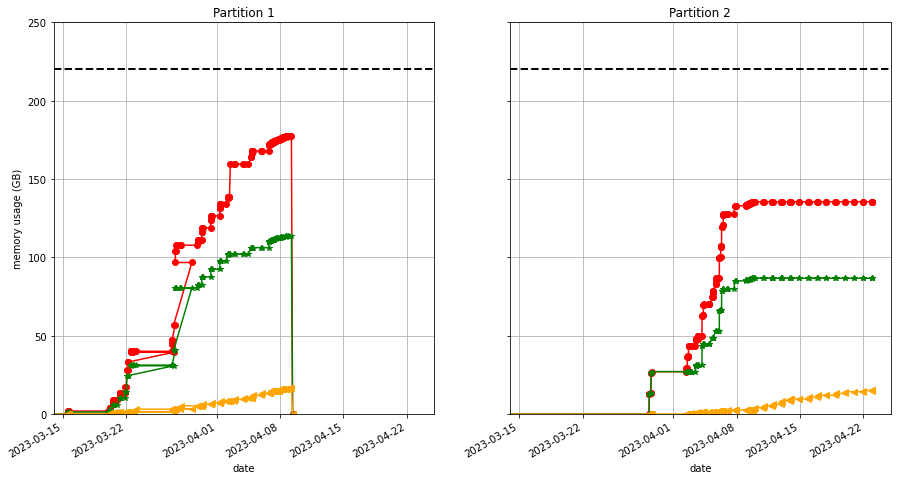

In [35]:
print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
# print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# print('TM time:',round((PHI.part1.compr + PHI.part2.compr)/2151.3,2), 'days')
# PHI.format_partition(1,DT(2023,1,29,16,0,0))
# PHI.format_partition(2,end + TD(hours=1))
# PHI.format_partition(1,end + TD(hours=1))
# PHI.format_partition(2,PHI.part1.history['end'][-1] + TD(hours=.5))
PHI.format_partition(1,DT(2023,4,9,6,10,0))
xlim = (DT(2023,3,14,0,0,0),DT(2023,4,25,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)


## <span style="color:blue">Nanoflares 4</span>
6h QS

In [36]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-04-10T00:00:00')
t1 = DT.fromisoformat('2023-04-10T06:00:00')
QS = PHI_MODE('HRT')
crop = 1408

kw = QS.observation(t0,t1,cadence=1,shape=(2048,crop,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = QS.cropping(DT(2023,4,11,11,0,0),crop=crop,ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = QS.packing(kw['end']+TD(minutes=5),ndata=-1,level = 'raw.crop'); phi.saving(id,**kw); PHI.saving(id,**kw)
QS, kw = flush_many([500,500],34,QS,DT(2023,5,10,22,0,0),6,-1,'raw.crop.pack',id)

########################################################
printp(QS, label='Nanoflares QS')


Days needed: 28
Nanoflares QS
number of datasets: 360
cadence: 1 mins
duration: 6:00:00
amount of raw-data at 32 bits: 98877.0 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 68664.6 MiB, 190.7 MiB per dataset
cropping time: 7:00:00
amount of pack-data at 16 bits: 35705.6 MiB, 99.2 MiB per dataset
packing time: 9:00:00
amount of compressed data + metadata at 6 bits: 12254.3 MiB, 34.0 MiB per dataset
compressing (+ flushing) time: 1 day, 4:33:16.853760
amount of metadata:  8640.081 MiB
amount of memory usage: 203247.1 MiB



## <span style="color:blue">RS-burst 4</span>

In [37]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-10T08:00:00')
t1 = DT.fromisoformat('2023-04-10T11:30:00')
RShrt4 = PHI_MODE('HRT')
RSfdt4 = PHI_MODE('FDT')

kw = RShrt4.observation(t0,30,cadence=1,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RSfdt4.observation(t0+TD(minutes=30),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RShrt4.packing(DT(2023,4,10,12,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RSfdt4.packing(DT(2023,4,10,13,0,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = RSfdt4.compressing(DT(2023,4,10,22,30,0),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
RShrt4, kw = flush_many([800,800],72,RShrt4,DT(2023,4,26,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(RShrt4, label='RS-burst HRT 4')
printp(RSfdt4, label='RS-burst FDT 4')

Days needed: 4
RS-burst HRT 4
number of datasets: 30
cadence: 1 mins
duration: 0:30:00
amount of raw-data at 32 bits: 11901.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 6179.8 MiB, 206.0 MiB per dataset
packing time: 0:45:00
amount of compressed data + metadata at 6 bits: 2160.3 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 5:02:01.553280
amount of metadata:  480.0 MiB
amount of memory usage: 18081.7 MiB

RS-burst FDT 4
number of datasets: 3
cadence: 60 mins
duration: 3:00:00
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 618.0 MiB, 206.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 216.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:30:12.155328
amount of metadata:  48.027 MiB
amount of memory usage: 1808.2 MiB



## <span style="color:green">HRT Flat 3</span>

In [38]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-11T00:00:00')
t1 = DT.fromisoformat('2023-04-11T10:00:00')
HRTflat2 = HRT_flat(t0,id,verbose=False)
########################################################
printp(HRTflat1, label="HRT FLAT 3 (11/04/2023)")

HRT FLAT 3 (11/04/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:blue">Density Fluctuations</span>

In [39]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-04-12T00:00:00')
t1 = DT.fromisoformat('2023-04-15T00:00:00')
DF = PHI_MODE('FDT')

synoptic_raw(DF,t0,t1,360,(2048,2048,4,6),6,id)

########################################################
printp(DF, label='Density Fluctuations')


Density Fluctuations
number of datasets: 12
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 4760.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2471.9 MiB, 206.0 MiB per dataset
packing time: 0:18:00
amount of compressed data + metadata at 6 bits: 864.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 2:00:48.621312
amount of metadata:  16.009 MiB
amount of memory usage: 7232.7 MiB



## <span style="color:blue">Nanoflares 5</span>

In [40]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-15T02:00:00')
t1 = DT.fromisoformat('2023-04-15T05:00:00')
nanohrt3 = PHI_MODE('HRT')
nanofdt3 = PHI_MODE('FDT')

kw = nanohrt3.observation(t0,30,cadence=1,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt3.observation(t0+TD(minutes=30),t1,cadence=60,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanohrt3.packing(DT(2023,4,6,5,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt3.packing(DT(2023,4,6,6,30,0),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = nanofdt3.compressing(DT(2023,4,6,22,30,0),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
nanohrt3, kw = flush_many([1200,1200],72,nanohrt3,DT(2023,4,15,22,0,0),6,-1,'raw.pack',id)

########################################################
printp(nanohrt3, label='Nanoflares HRT 5')
printp(nanofdt3, label='Nanoflares FDT 5')


Days needed: 3
Nanoflares HRT 3
number of datasets: 30
cadence: 1 mins
duration: 0:30:00
amount of raw-data at 32 bits: 11901.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 6179.8 MiB, 206.0 MiB per dataset
packing time: 0:45:00
amount of compressed data + metadata at 6 bits: 2160.3 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 5:02:01.553280
amount of metadata:  480.0 MiB
amount of memory usage: 18081.7 MiB

Nanoflares FDT 3
number of datasets: 2
cadence: 60 mins
duration: 2:30:00
amount of raw-data at 32 bits: 793.5 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 412.0 MiB, 206.0 MiB per dataset
packing time: 0:03:00
amount of compressed data + metadata at 6 bits: 144.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:20:08.103552
amount of metadata:  32.018 MiB
amount of memory usage: 1205.4 MiB



## <span style="color:green">FDT Flat 4</span>

In [41]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-15T13:00:00')
t1 = DT.fromisoformat('2023-04-15T14:00:00')
FDTflat4 = FDT_flat(t0,id,verbose=False)
kw = FDTflat4.packing(DT(2023,4,15,17,0,0),ndata=9,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = FDTflat4.compressing(kw['end']+TD(minutes=10),ndata=9,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(FDTflat2, label="FDT FLAT 4 (15/04/2023)")

FDT FLAT 4 (15/04/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2059.9 MiB, 206.0 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 720.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:40:40.517760
amount of metadata:  80.081 MiB
amount of memory usage: 6027.2 MiB



## <span style="color:green">HRT Flat 4</span>

In [42]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-16T00:00:00')
t1 = DT.fromisoformat('2023-04-16T10:00:00')
HRTflat4 = HRT_flat(t0,id,verbose=False)
########################################################
printp(HRTflat4, label="HRT FLAT 4 (16/04/2023)")

HRT FLAT 4 (16/04/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



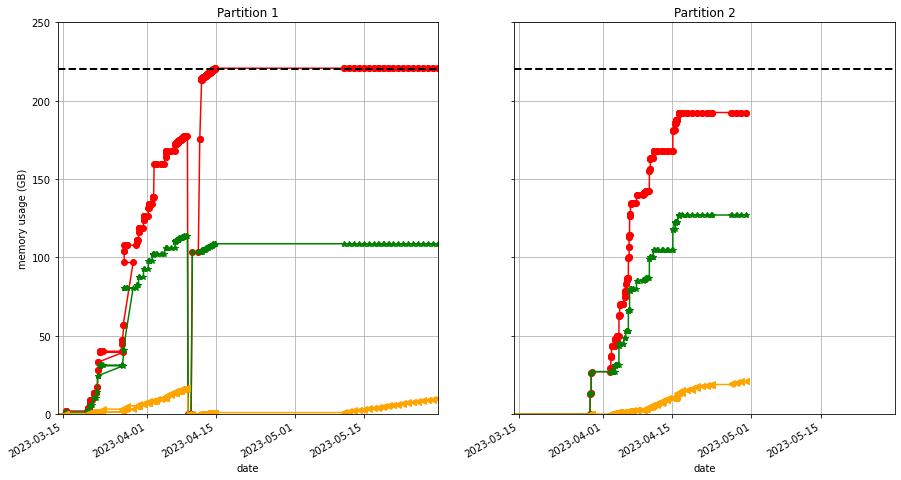

In [43]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,5,30,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)


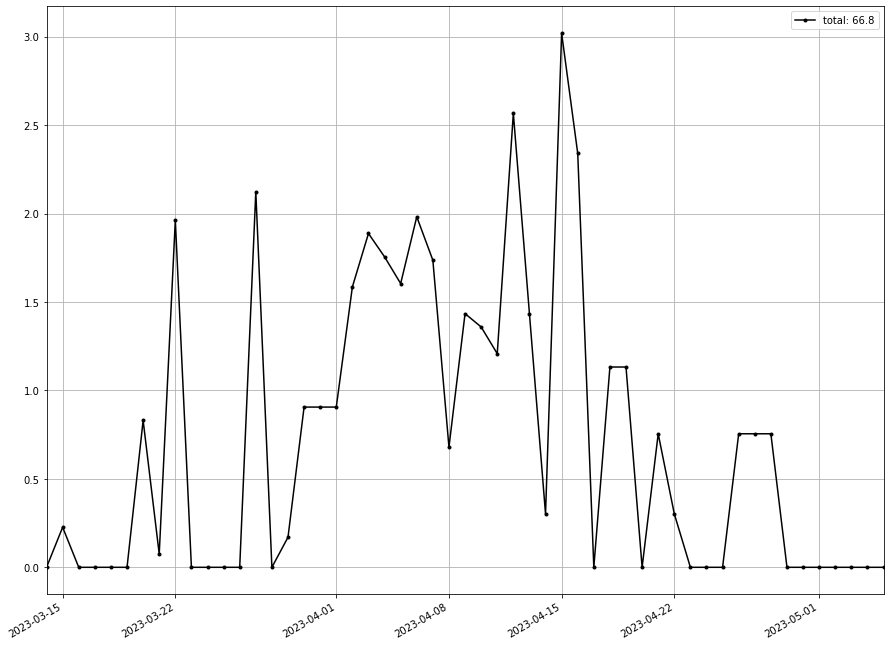

In [44]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,5,5,0,0,0))
plot_flush_per_day(PHI,xlim)

# <span style="color:magenta">*RSW 9*</span>

## <span style="color:blue">Coronal Dynamics 2</span>

In [45]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-20T00:00:00')
t1 = DT.fromisoformat('2023-04-20T18:00:00')
CD2 = PHI_MODE('FDT')

synoptic_raw(CD2,t0,t1,120,(2048,2048,4,6),6,id)

########################################################
printp(CD2, label='Coronal Dynamics 2')


Coronal Dynamics 2
number of datasets: 9
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 3570.6 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1853.9 MiB, 206.0 MiB per dataset
packing time: 0:13:30
amount of compressed data + metadata at 6 bits: 648.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:30:36.465984
amount of metadata:  16.009 MiB
amount of memory usage: 5424.5 MiB



## <span style="color:blue">Connection Mosaic 2</span>

In [46]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-20T18:00:00')
t1 = DT.fromisoformat('2023-04-22T18:18:51')
CM2 = PHI_MODE('HRT')

synoptic_raw(CM2,t0,t1,240,(2048,2048,4,6),6,id)

########################################################
printp(CM2, label='Connection Mosaic 2')


Connection Mosaic 2
number of datasets: 12
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 4760.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2471.9 MiB, 206.0 MiB per dataset
packing time: 0:18:00
amount of compressed data + metadata at 6 bits: 864.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 2:00:48.621312
amount of metadata:  16.009 MiB
amount of memory usage: 7232.7 MiB



## <span style="color:blue">Slow Wind Connection 2</span>

In [47]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-22T18:00:00')
t1 = DT.fromisoformat('2023-04-24T21:00:00')
SW2 = PHI_MODE('HRT')

kw = SW2.observation(t0,12,cadence=5,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW2.observation(t0+TD(days=1),12,cadence=5,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

kw = SW2.observation(t0+TD(days=2),12,cadence=5,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = SW2.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(SW2, label='Slow Wind Connection 2')


Slow Wind Connection 2
number of datasets: 36
cadence: 5 mins
duration: 1:00:00
amount of raw-data at 32 bits: 14282.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 7415.8 MiB, 206.0 MiB per dataset
packing time: 0:54:00
amount of compressed data + metadata at 6 bits: 2592.3 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 6:02:25.863936
amount of metadata:  192.108 MiB
amount of memory usage: 21698.0 MiB



## <span style="color:blue">Polar Observations 2</span>

In [48]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-24T21:00:00')
t1 = DT.fromisoformat('2023-04-25T00:00:00')
polar2 = PHI_MODE('HRT')

kw = polar2.observation(t0,12,cadence=5,shape=(2048,2048,4,6)); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = polar2.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)

########################################################
printp(polar2, label='Polar observations 2')


Polar observations 2
number of datasets: 12
cadence: 5 mins
duration: 1:00:00
amount of raw-data at 32 bits: 4760.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2471.9 MiB, 206.0 MiB per dataset
packing time: 0:18:00
amount of compressed data + metadata at 6 bits: 864.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 2:00:48.621312
amount of metadata:  192.108 MiB
amount of memory usage: 7232.7 MiB



## <span style="color:green">FDT Flat 5</span>

In [49]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-04-25T10:00:00')
t1 = DT.fromisoformat('2023-04-25T11:00:00')
FDTflat3 = FDT_flat(t0,id,DT(2023,4,26,1,0,0),verbose=False)
########################################################
printp(FDTflat3, label="FDT FLAT 5 (06/04/2023)")

FDT FLAT 5 (06/04/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4173.3 MiB



## <span style="color:green">HRT Flat 5</span>

In [50]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-04-25T11:00:00')
t1 = DT.fromisoformat('2023-04-25T21:00:00')
HRTflat5 = HRT_flat(t0,id,verbose=False)
########################################################
printp(HRTflat4, label="HRT FLAT 5 (25/04/2023)")

HRT FLAT 5 (25/04/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



# <span style="color:yellow">PLOTS</span>

We should try to format partition two at some point, in this way we could add more FDT synoptic during and after RSWs.

Implementing CROP+Pack would save ~70 GB of memory in NAND1

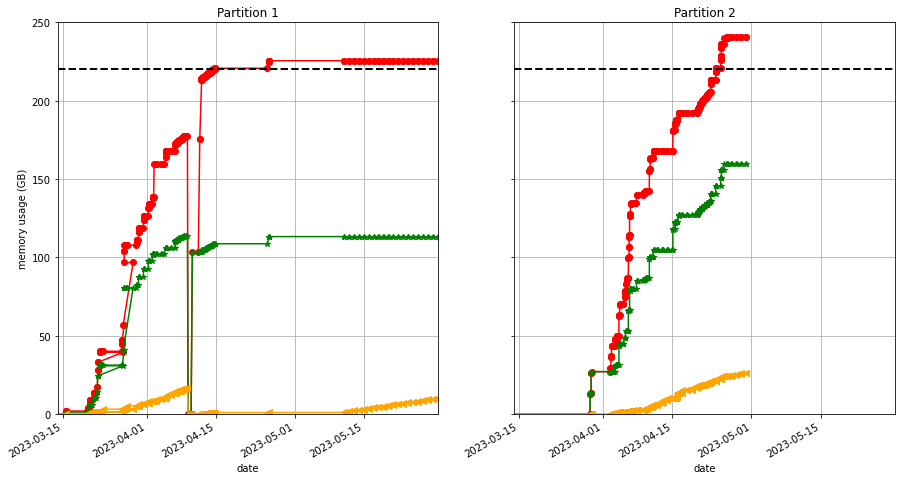

In [51]:
xlim = (DT(2023,3,14,0,0,0),DT(2023,5,30,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)
# plt.savefig('/home/calchetti/MPStemp/pics/TM/total_v5.1.png')

# fname = '/home/calchetti/MPStemp/PHI_TMtool/TM_NMP1_v2.csv'
# PHI.save(fname)

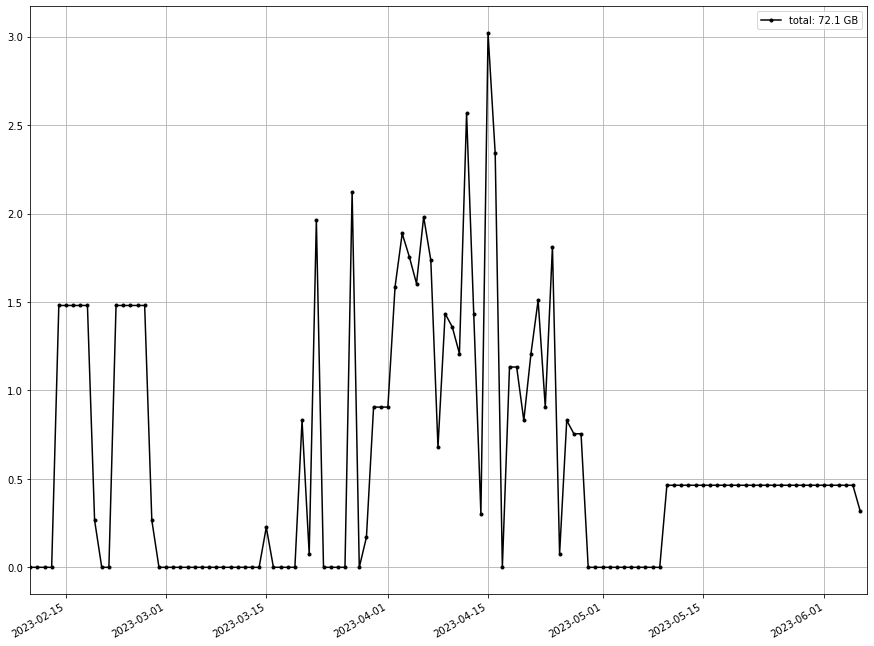

In [56]:
xlim = (DT(2023,2,10,0,0,0),DT(2023,6,7,0,0,0))
plot_flush_per_day(PHI,xlim)

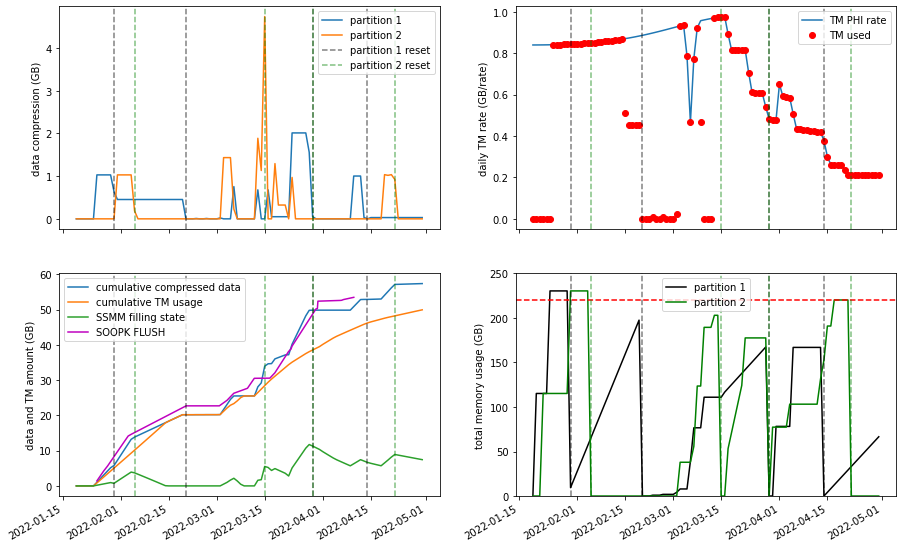

In [50]:
from scipy.interpolate import interp1d
tot1 = np.asarray(PHI.part1.history['occu'])
tot2 = np.asarray(PHI.part2.history['occu'])
c1 = np.asarray(PHI.part1.history['compr'])
c2 = np.asarray(PHI.part2.history['compr'])
d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

starttime = min(d1[0],d2[0])
endtime = max(d1[-1],d2[-1])
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += TD(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

s = np.argsort(d1)

newtot1 = np.zeros(np.size(times))
for i,j in zip(d1,tot1):
    if True:
        ind = np.where(times == i.date())[0]
        newtot1[ind] += j/1e3
newtot1 = np.asarray(newtot1)

newtot2 = np.zeros(np.size(times))
for i,j in zip(d2,tot2):
    if True:
        ind = np.where(times == i.date())[0]
        newtot2[ind] += j/1e3
newtot2 = np.asarray(newtot2)

newc1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc1[ind] += j/1e3
newc1 = np.asarray(newc1)


newc2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc2[ind] += j/1e3
newc2 = np.asarray(newc2)

form1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j<0:
        ind = np.where(times == i.date())[0]
        form1[ind] += j/1e3
form1 = np.asarray(form1)


form2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j<0:
        ind = np.where(times == i.date())[0]
        form2[ind] += j/1e3
form2 = np.asarray(form2)

trig1 = np.where(form1 < 0)[0]
trig2 = np.where(form2 < 0)[0]

x = TM3['date'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]
y = TM3['tm_rate'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]
z = TM3['duration'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]

xx = [(i - starttime).total_seconds() for i in x]
f = interp1d(xx, y*z)
xnew = [(i - starttime.date()).total_seconds() for i in times]
ynew = f(xnew)/8e9
ynew[times<datetime.date(2023,4,1)] *= .2
ynew[times>=datetime.date(2023,4,1)] *= .3

tm_used = np.zeros(times.size)
down = 0#np.zeros(times.size)
for i in range(times.size):
    if newc1[i] > 0 or newc2[i] > 0:
        tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
        down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))
    else:
        if down > 0:
            tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
            down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.ylabel('data compression (GB)')
plt.plot(times,newc1,label='partition 1')
plt.plot(times,newc2,label='partition 2')
for i,t in enumerate(trig1):
    if i == 0:
        plt.axvline(times[t],linestyle='--',color='k',alpha=.5,label='partition 1 reset')
    else:
        plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for i,t in enumerate(trig2):
    if i == 0:
        plt.axvline(times[t],linestyle='--',color='g',alpha=.5,label='partition 2 reset')
    else:
        plt.axvline(times[t],linestyle='--',color='g',alpha=.5)
plt.legend()

plt.subplot(222)
plt.ylabel('daily TM rate (GB/rate)')
plt.plot(times,ynew,label='TM PHI rate')
plt.plot(times,tm_used,'ro',label='TM used')
plt.legend()
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)
# print('total TM used:',round(tm_used.sum(),2),'GB')
# print('total compressed data:',round((newc1+newc2).sum(),2),'GB')
# plt.xlim(datetime.date(2023,1,10),datetime.date(2023,2,5))
plt.subplot(223)
plt.ylabel('data and TM amount (GB)')
plt.plot(times,np.cumsum(newc1+newc2),label='cumulative compressed data')
plt.plot(times,np.cumsum(tm_used),label='cumulative TM usage')
plt.plot(times,np.cumsum(newc1+newc2)-np.cumsum(tm_used),label='SSMM filling state')
# cond = np.logical_and(FL['date']>DT(2023,1,19,0,0), FL['date']<DT(2023,5,1,0,0))
# plt.plot(FL['date'][cond],-np.cumsum(FL['flush'][cond]*2**20/1e9),'m',label='SOOPK FLUSH')
plt.legend()
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)

plt.subplot(224)
plt.ylabel('total memory usage (GB)')
plt.plot(times,np.cumsum(newtot1),'k',label='partition 1')
plt.plot(times,np.cumsum(newtot2),'g',label='partition 2')
plt.legend()
plt.ylim(0,250)
plt.axhline(220,linestyle='--',color='r')
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)

plt.gcf().autofmt_xdate()
# plt.savefig('/home/calchetti/MPStemp/pics/TM/tm_v5.1.png')

In [51]:
print('Total amount of TM used:',round(tm_used.sum(),2),'GB')
print('Total amount of compressed data:',round((newc1+newc2).sum(),2),'GB')

Total amount of TM used: 49.93 GB
Total amount of compressed data: 57.38 GB


In [52]:
(newc1+newc2)[times<datetime.date(2023,5,1)].sum()

57.37513452000002